In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
sns.set_theme(style='whitegrid')

In [36]:
model_path = './log_SGD_continue_1e-4/transformer_29_map0.9159278553764464_acc0.5036038160324097.pth'

# VAL SET

In [3]:
with open('./log_SGD_continue_1e-4/val_set_distances.pkl', 'rb') as f:
    (inter_class_distances, intra_class_distances) = pickle.load(f)

In [32]:
max_value_of_both = max(max(inter_class_distances), max(intra_class_distances))
min_value_of_both = min(min(inter_class_distances), min(intra_class_distances))

bin_size = 1e-6
bins = np.arange(min_value_of_both, max_value_of_both + bin_size, bin_size)

intra_hist, _ = np.histogram(intra_class_distances, bins=bins)
inter_hist, _ = np.histogram(inter_class_distances, bins=bins)

In [23]:
np.arange(0,7,1)

array([0, 1, 2, 3, 4, 5, 6])

In [27]:
bins = [0, 1, 2, 3, 4, 5, 6]
intra_hist = [0, 2, 3, 1, 0, 0, 0]
inter_hist = [0, 0, 0, 2, 1, 3, 2]
bin_size = 1

In [33]:
tp = 0
tn = np.sum(inter_hist)
total = np.sum(intra_hist) + tn
accs = np.array([]) 
for i, bin in enumerate(bins[:-1]):
    num_intra = intra_hist[i]
    num_inter = inter_hist[i]
    tp += num_intra
    tn -= num_inter
    acc = (tp + tn) / total
    accs = np.append(accs, acc)

# find the index with the highest accuracy
max_acc_index = np.argmax(accs)
optimal_thresh = bins[max_acc_index] + bin_size

# find the sum of intra_hist from max_acc_index to the end
fn = np.sum(intra_hist[max_acc_index+1:])
# find the sum of inter_hist from the beginning to max_acc_index
fp = np.sum(inter_hist[:max_acc_index])

intersection_area = fn + fp

print(optimal_thresh, accs[max_acc_index], intersection_area)

0.0009472894954681371 0.9643391699267427 51353


# TEST SET

In [34]:
with open('./log_SGD_continue_1e-4/collated_test_set_distances.pkl', 'rb') as f:
    collated_distances = pickle.load(f)

In [41]:
from scipy.stats import gaussian_kde
kde = gaussian_kde(collated_distances)
x = np.linspace(np.min(collated_distances), np.max(collated_distances), num=1000)
kde_plot = kde(x)

In [44]:
gradient = np.gradient(kde_plot)
# Find the indices where the gradient changes sign (stationary points)
stationary_indices = np.where(np.diff(np.sign(gradient)))[0]
stationary_indices

array([131, 305, 575])

In [45]:
x[stationary_indices]

array([0.00055705, 0.00117424, 0.00213194])

Text(0.5, 1.0, 'Test Set Separation Chart [euclidean Distance]\nModel: ./log_SGD_continue_1e-4/transformer_29_map0.9159278553764464_acc0.5036038160324097.pth')

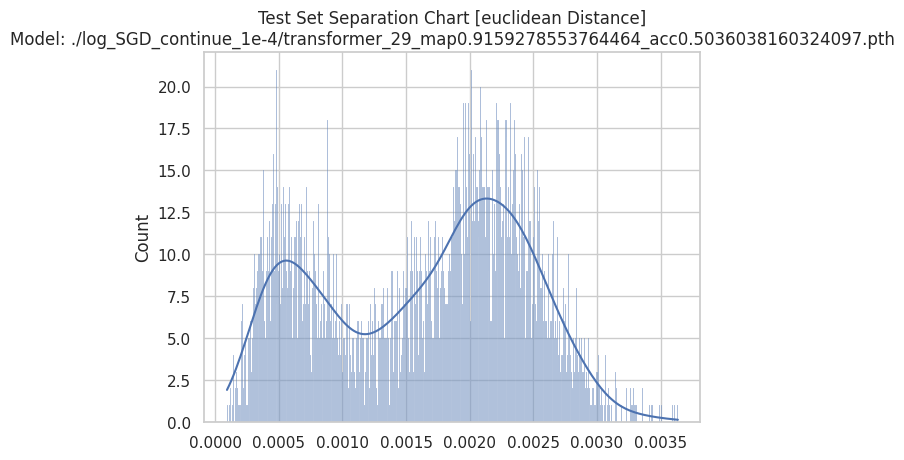

In [38]:
sns.histplot(collated_distances, bins=500, kde=True)
plt.title(f'Test Set Separation Chart [euclidean Distance]\nModel: {model_path}')